# CIFAR-10 dataset - ResNet with Data Augmentation

In this notebook, I am going to assess the performances of ResNet for image classifications on the images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. 

The experimental process is the following:

- Import CIFAR-10 dataset
- Pre-process the data 
    - Normalization of the images
    - One hot encoding of the labels
- Augment the data with random:
    - Rotations
    - Shifts
    - Scale Variation (zoom)
    - Flips
- Import the base model pre trained on Image Net
- Freeze the weights 
- Add a simple output network
- Fine tune the overall network by training the last layer
- Analyse results

All the implementation will be carried out in Keras (tensorflow backend) on our personal laptop. 

## Data Import

The utilities function to download the dataset have been reused from the code shared by Park Chansung through [his medium article](https://towardsdatascience.com/transfer-learning-in-tensorflow-9e4f7eae3bb4).

In [4]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm 
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DownloadProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num
        
if not isfile('cifar-10-python.tar.gz'):
    with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


In [5]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
image_size = 32

def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, image_size, image_size)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

## Preprocess the Data to Merge Batches and Prepare the Split

The CIFRAR dataset is provided divided into multiple files (batches). We will now merge all the batches into one single set of training data. Given the utilities provided by Keras we do not need to apply any Train-Validation split as it will be automatically be performed by the training procedure.

This does introduce a small bias due to the fact that validation items are normalised together with the training data and not separately. Given that the validation split only compares the model with itself we do not need to take care about this bias as long as its existance is acknowledged when evaluating the absolute value of the validation loss.

The test data is also loaded and preprocessed independently.

In [75]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from copy import deepcopy
import time

session_id = int(time.time())

def preprocess_and_save(features, labels, filename=None):
    features = preprocess_input(features)
    labels = to_categorical(labels)
    if filename is not None:
        pickle.dump((features, labels), open(filename, 'wb'))
    return features, labels

def build_and_save_splits(cifar10_dataset_folder_path):
    n_batches = 5
    valid_features = []
    valid_labels = []
    features = np.empty((0,32,32,3))
    labels = []
    
    for batch_i in range(1, n_batches + 1):
        features_, labels_ = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        features = np.concatenate((features,features_))
        labels += labels_
    
    original_features = deepcopy(features)
    # validation_size = int(len(features) * 0.1)
    X_train, y_train = preprocess_and_save(features, labels, "data/{}-train.pkl".format(session_id))
    # X_val, y_val = preprocess_and_save(features[-validation_size:], labels[-validation_size:], "data/validation.pkl")

    
    # load the test dataset
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # preprocess the testing data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']
    original_test_features = deepcopy(test_features)
    
    # Preprocess and Save all testing data
    X_test, y_test = preprocess_and_save(np.array(test_features), np.array(test_labels),
                         'data/{}-test.pkl'.format(session_id))
    

In [76]:
build_and_save_splits(cifar10_dataset_folder_path)

## Checkpoint


In [25]:
# Run this cell with the timestamp of the run to be loaded if you want to load a different checkpoint
if False:
    session_id = 1596617066

In [9]:
import pickle

X_train, y_train = pickle.load(open('data/{}-train.pkl'.format(session_id), mode='rb'))
# X_val, y_val = pickle.load(open('data/validation.pkl', mode='rb'))
X_test, y_test = pickle.load(open('data/{}-test.pkl'.format(session_id), mode='rb'))

In [10]:
from tensorflow.keras.applications import ResNet50

# Init the VGG model 
res_net = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

Instructions for updating:
Colocations handled automatically by placer.


/Users/nicovendramin/.pyenv/versions/3.7.5/envs/data_science/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [11]:
# Freeze all the layers
for layer in res_net.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in res_net.layers:
    print(layer, layer.trainable)
    
res_net.summary()

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x131261850> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x130c02dd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x130193390> False
<tensorflow.python.keras.layers.normalization.BatchNormalizationV1 object at 0x1312612d0> False
<tensorflow.python.keras.layers.core.Activation object at 0x130c859d0> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x106daf410> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x1401aaad0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1401c8050> False
<tensorflow.python.keras.layers.normalization.BatchNormalizationV1 object at 0x1311b16d0> False
<tensorflow.python.keras.layers.core.Activation object at 0x140281a10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x140281310> False
<tensorflow.python.keras.layers.normalization.BatchNormalization

In [12]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

# Create the model
model = Sequential()

# Add the vgg convolutional base model
model.add(res_net)
model.summary()

# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropou

In [13]:
from tensorflow.keras import optimizers

model.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.0,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

In [15]:
eighty = int(80*len(X_train)/100)
X_val, y_val = X_train[eighty:], y_train[eighty:]
X_train, y_train = X_train[:eighty], y_train[:eighty]

print(X_train.shape)

(40000, 32, 32, 3)


In [16]:
training_data = None
training_labels = None

# We add the equivalent of 50% of the training data in augmented batches
total_batches = int(len(X_train) / 256 / 2)
for batch in range(0, total_batches):
    if batch % 13 == 0:
        print("{}/{} ({:.2f}%)".format(batch, total_batches, batch/total_batches*100))
    x_batch, y_batch = generator.flow(X_train, y_train, batch_size=256).next()
    if training_data is None:
        training_data = np.copy(x_batch)
        training_labels = np.copy(y_batch)
    else:
        training_data = np.concatenate((training_data, x_batch))
        training_labels = np.concatenate((training_labels, y_batch))

print(training_data.shape)
print(training_labels.shape)

0/78 (0.00%)
13/78 (16.67%)
26/78 (33.33%)
39/78 (50.00%)
52/78 (66.67%)
65/78 (83.33%)
(19968, 32, 32, 3)
(19968, 10)


In [17]:
X_train = np.concatenate((X_train, training_data))
y_train = np.concatenate((y_train, training_labels))

In [18]:
print(X_val.shape)
print(y_val.shape)

(10000, 32, 32, 3)
(10000, 10)


In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'models/res-model-augm-{}.h5'.format(session_id), 
    monitor='val_acc', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

# Train the model
history = model.fit(
    x=X_train,
    y=y_train,
    validation_split=0.2,
    batch_size=512,
    epochs=60,
    callbacks=[checkpoint],
    verbose=1
)

Train on 47974 samples, validate on 11994 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/60
47974/47974 [==============================] - 138s 3ms/sample - loss: 2.6933 - acc: 0.2118 - val_loss: 3.1262 - val_acc: 0.2907
Epoch 2/60
47974/47974 [==============================] - 137s 3ms/sample - loss: 2.1047 - acc: 0.3261 - val_loss: 3.1171 - val_acc: 0.3199
Epoch 3/60
47974/47974 [==============================] - 150s 3ms/sample - loss: 1.9234 - acc: 0.3713 - val_loss: 3.1001 - val_acc: 0.3277
Epoch 4/60
47974/47974 [==============================] - 133s 3ms/sample - loss: 1.8006 - acc: 0.3986 - val_loss: 2.9363 - val_acc: 0.3394
Epoch 5/60
47974/47974 [==============================] - 134s 3ms/sample - loss: 1.7161 - acc: 0.4216 - val_loss: 2.9688 - val_acc: 0.3399
Epoch 6/60
47974/47974 [==============================] - 133s 3ms/sample - loss: 1.6624 - acc: 0.4369 - val_loss: 2.9177 - val_acc: 0.3453
Epoch 7/60
47974/47974 [==============================] - 132s

KeyboardInterrupt: 

We interrupted the cell above as the validation error was not improving.

### Show Stats


<AxesSubplot:>

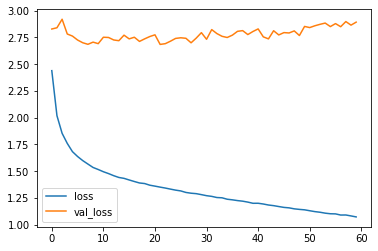

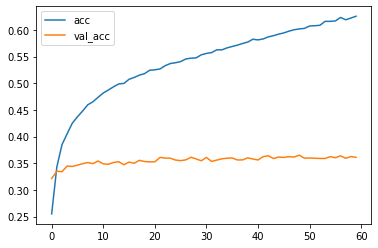

In [21]:
import json
import pandas as pd
#with open('history.json', 'w') as f:
#    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

### Fully Train the Model

In [20]:
model.load_weights('models/res-model-augm-{}.h5'.format(session_id))
train_loss, train_score = model.evaluate(X_train, y_train)
test_loss, test_score = model.evaluate(X_test, y_test)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)
print("Train F1 Score:", train_score)
print("Test F1 Score:", test_score)

10000/10000 [==============================] - 29s 3ms/sample - loss: 2.3239 - acc: 0.4311
Train Loss: 2.42722948552323
Test Loss: 2.3239414730072023
Train F1 Score: 0.4111026
Test F1 Score: 0.4311


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Example of Image:
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane
Predicted Label - Label Id: 1 Name: automobile


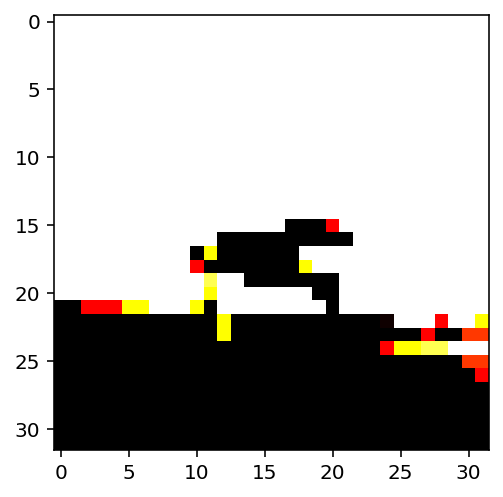

In [21]:
def predict_vector(sample):
    vector = model.predict(np.reshape(sample, (1,32,32,3)))[0]
    return vector

def predict_label(sample):
    vector = model.predict(np.reshape(sample, (1,32,32,3)))[0]
    return to_label_id(vector)
    
def to_label_id(label_vector):
    return np.argmax(label_vector)

def display_stats(sample_image, sample_label, predicted_label):
    
    label_names = load_label_names()
    
    print('\nExample of Image:')
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    print('Predicted Label - Label Id: {} Name: {}'.format(predicted_label, label_names[predicted_label]))
    
    plt.imshow(sample_image)
    
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
import random
image_id = random.randint(0, len(X_test))
display_stats(X_train[image_id], to_label_id(y_train[image_id]), predict_label(X_train[image_id]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


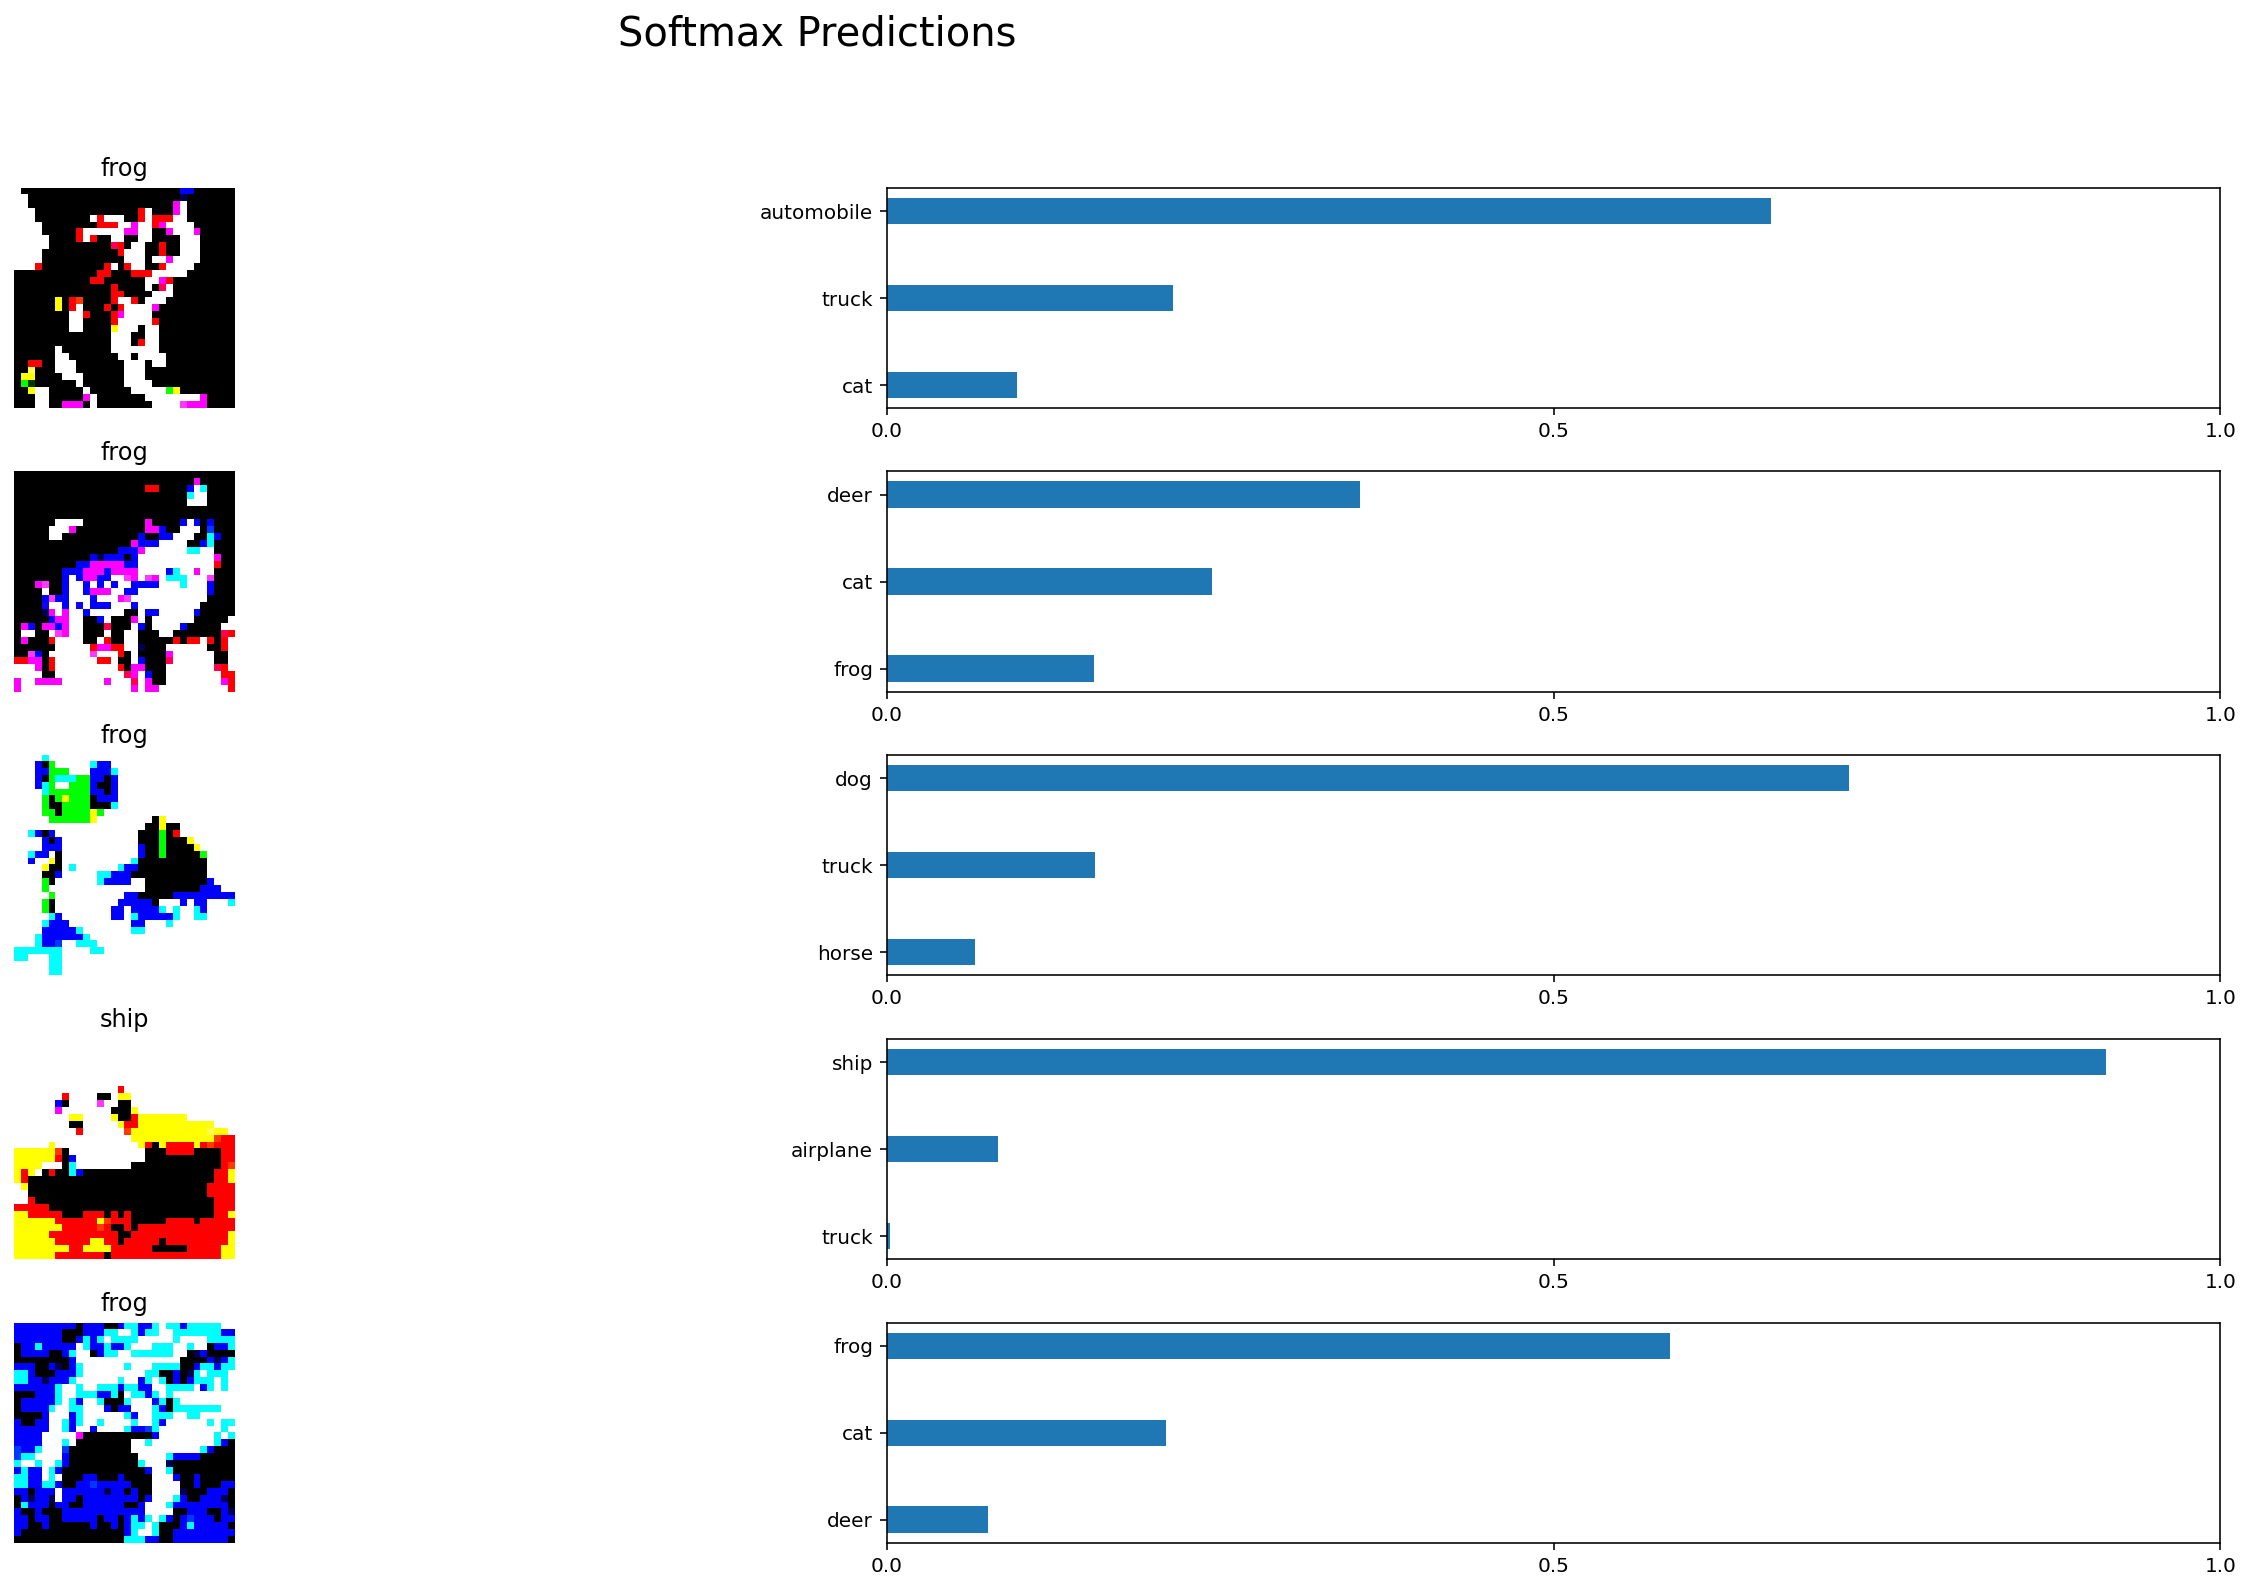

In [22]:
def random_sample(X, y, k):
    a = list(np.arange(0, len(X)))
    c = random.sample(a, k)
    sample_X = []
    sample_y = []
    for i in c:
        sample_X.append(X[i])
        sample_y.append(y[i])
    return sample_X, sample_y

random_sample(X_test, y_test, 12)

def display_image_predictions(features, labels, top_n_predictions):
    n_classes = 10
    label_names = load_label_names()
    label_ids = [to_label_id(label) for label in labels]
    predictions = [predict_vector(feature) for feature in features]
    predictions_indices = []
    predictions_values = []
    for prediction in predictions:
        a = np.arange(0, len(prediction))
        b = list(zip(list(a), prediction))
        b = sorted(b, key=lambda x: x[1])
        c = list(map(lambda x: x[0], b))
        d = list(map(lambda x: x[1], b))
        predictions_indices.append(c[-top_n_predictions:])
        predictions_values.append(d[-top_n_predictions:])
        
    fig, axies = plt.subplots(nrows=top_n_predictions, ncols=2, figsize=(20, 10))
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions
   
    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions_indices, predictions_values)):
        if (image_i < top_n_predictions):
            pred_names = [label_names[pred_i] for pred_i in pred_indicies]
            correct_name = label_names[label_id]
            
            axies[image_i][0].imshow((feature*255).astype(np.int32, copy=False))
            axies[image_i][0].set_title(correct_name)
            axies[image_i][0].set_axis_off()

            axies[image_i][1].barh(ind + margin, pred_values[-3:], width)
            axies[image_i][1].set_yticks(ind + margin)
            axies[image_i][1].set_yticklabels(pred_names[-3:])
            axies[image_i][1].set_xticks([0, 0.5, 1.0])

features_, labels_ = random_sample(X_test, y_test, 12)

display_image_predictions(features_, labels_, 5)


In [23]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          title="Confusion Matrix",
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    #Print Confusion matrix
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

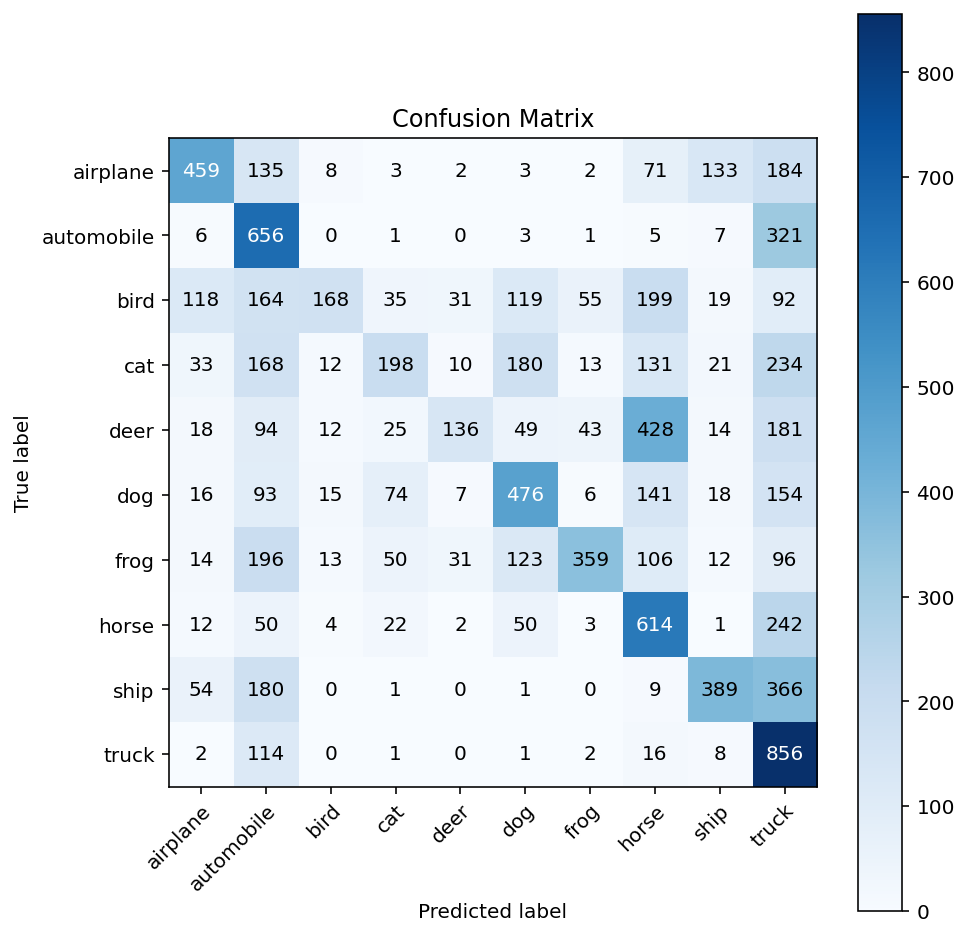

In [24]:
#Making prediction
y_pred=model.predict_classes(X_test)
y_true=np.argmax(y_test,axis=1)

#Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mtx=confusion_matrix(y_true,y_pred)

class_names= load_label_names()

# Plotting non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes = class_names)